In [1]:
from UDP_profiler import JobPreparer, DataProcessor, Plotter
import openeo
from job_management import MultiBackendJobManager
import pandas as pd

# Define your constants and parameters
process_graph_path = 'NDWI.json'
spatial_range = [10000, 20000, 40000] #km extend
temporal_range = [3, 6, 12] #months
repetition = 3
output_file_prefix = "UDP_Profile"

# Initialize the JobPreparer
job_preparer = JobPreparer(process_graph_path)

# Prepare the jobs DataFrame
jobs_df = job_preparer.prepare_jobs_df(temporal_range, spatial_range, repetition=repetition)

# Generate an output filename
output_file = job_preparer.generate_output_filename(output_file_prefix, job_preparer.process_graph["id"])
manager = MultiBackendJobManager()  

# Authenticate and add the backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
manager.add_backend("cdse", connection=connection, parallel_jobs=10)

# Define the start_job function
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row and connection."""
    process_graph_path = row["process_graph_path"]
    spatial_extent = row["spatial_extent"]
    temporal_extent = row["temporal_extent"]

    cube = connection.datacube_from_json(
        process_graph_path,
        parameters={"spatial_extent": spatial_extent, "temporal_extent": temporal_extent}
    )
    
    return cube.create_job(
        title='Process Graph - Benchmark',
        format="netcdf"
    )

# Run the jobs
manager.run_jobs(df=jobs_df, start_job=start_job, output_file=output_file)




Authenticated using refresh token.


In [2]:
import pandas as pd
df = pd.read_csv(output_file)
data_processor = DataProcessor()
df = data_processor.update_job_costs(df, connection)
df = data_processor.add_units_to_column_headers(df)
df = data_processor.clean_units(df)

df.to_csv(output_file, index=False)

c:\Git_projects\apex_algorithms\udp_cost_mapping\UDP_profiler.py:159: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


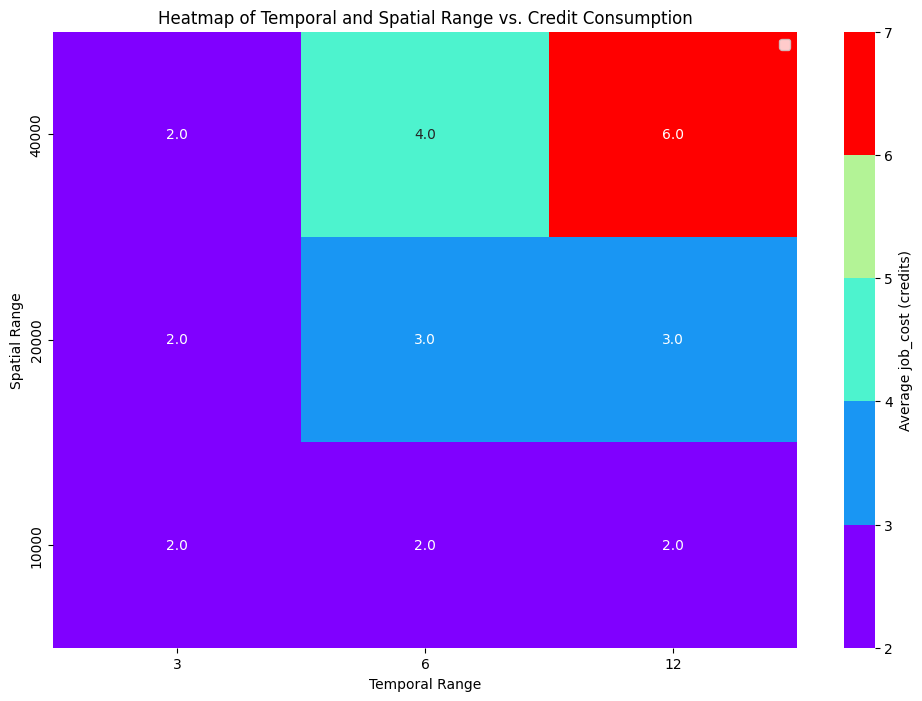

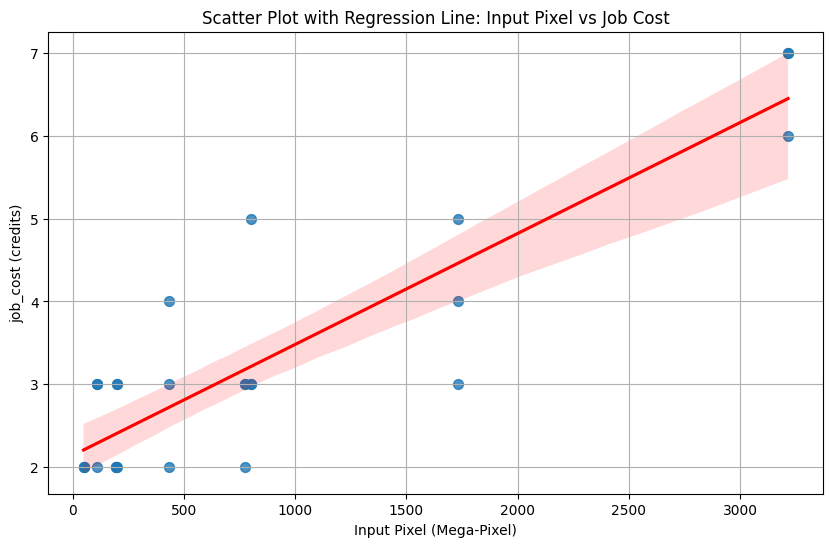

In [4]:
# Plotting

plotter = Plotter()
plotter.plot_heatmap(df, 'job_cost (credits)')
plotter.plot_scatter_with_fit(df, 'job_cost (credits)')